In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import visual_behavior.visualization.utils as ut
import visual_behavior.data_access.loading as loading
import visual_behavior.visualization.ophys.summary_figures as sf 
import visual_behavior.ophys.response_analysis.utilities as utilities
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

### get multi session dataframe for omission responses (over +/-5 second window round omission)

In [4]:
experiments_table = loading.get_filtered_ophys_experiment_table() 

In [5]:
cache_dir = loading.get_analysis_cache_dir()

df_name = 'trials_response_df' 
conditions = ['cell_specimen_id', 'change_image_name', 'go']
project_codes = ['VisualBehaviorMultiscope']
experiments = experiments_table[experiments_table.project_code.isin(project_codes)]

multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments)
multi_session_df = loading.remove_outlier_traces_from_multi_session_df(multi_session_df)
multi_session_df = loading.remove_problematic_data_from_multi_session_df(multi_session_df)


In [6]:
multi_session_df.head()

,cell_specimen_id,change_image_name,go,mean_response,sem_response,mean_trace,sem_trace,mean_responses,mean_baseline,sem_baseline,...,cre_line,location,location_layer,layer,ophys_session_id,project_code,specimen_id,depth,exposure_number,container_id
0,1018073087,im061,False,0.165931,0.087982,"[0.06331807872548559, 0.3565381217703642, 0.42...","[0.06702806063596621, 0.09243062341161704, 0.1...","[0.027717637963065478, 0.5363239410350759, -0....",0.243820,0.111046,...,Slc17a7-IRES2-Cre,Excitatory deep,Slc17a7_VISl_L5a,L5a,985609503,VisualBehaviorMultiscope,920877188,deep,0,1018028064
1,1018073087,im061,True,-0.058222,0.009224,"[0.020890610642338544, 0.008560763186246524, 0...","[0.013422491169666031, 0.016640606219803716, 0...","[-0.04094609860312837, -0.08447609659989007, -...",-0.025662,0.002028,...,Slc17a7-IRES2-Cre,Excitatory deep,Slc17a7_VISl_L5a,L5a,985609503,VisualBehaviorMultiscope,920877188,deep,0,1018028064
2,1018073087,im062,False,-0.010597,0.011130,"[-0.03507392802217693, -0.02719498171479165, -...","[0.0445451601983031, 0.02965016077270323, 0.03...","[0.007162918538285576, -0.017886947108377894, ...",-0.000018,0.003009,...,Slc17a7-IRES2-Cre,Excitatory deep,Slc17a7_VISl_L5a,L5a,985609503,VisualBehaviorMultiscope,920877188,deep,0,1018028064
3,1018073087,im062,True,0.040848,0.017759,"[0.04764057526508728, 0.07383561256517318, 0.0...","[0.021945327615038673, 0.029135327754466703, 0...","[0.010697407414426362, -0.010501211598308587, ...",0.053845,0.021044,...,Slc17a7-IRES2-Cre,Excitatory deep,Slc17a7_VISl_L5a,L5a,985609503,VisualBehaviorMultiscope,920877188,deep,0,1018028064
4,1018073087,im063,False,0.036245,0.024232,"[0.04716185026000217, -0.04752090770710395, 0....","[0.04820854606982941, 0.02455044441095449, 0.0...","[-0.01810004806167595, 0.09490728246215996, 0....",0.005392,0.003482,...,Slc17a7-IRES2-Cre,Excitatory deep,Slc17a7_VISl_L5a,L5a,985609503,VisualBehaviorMultiscope,920877188,deep,0,1018028064


### get data for omissions during engaged + running condition

In [7]:
df = multi_session_df.copy()
df = df[(df.go==True)]

In [8]:
df.mean_trace.values[0].shape

(107,)

### get all sessions matrix

### this will include multiple responses per cell because it is separated by image

In [9]:
cre_lines = df.cre_line.unique()

In [24]:
indices = [index for index in df.index.values if len(df.loc[index].mean_trace)!=107]

In [25]:
df = df.drop(index=indices)

In [26]:
all_sess_ns_fof_all_cre = {}
for cre_line in cre_lines:
    all_sess_ns_fof_all_cre[cre_line] = np.vstack(df[df.cre_line==cre_line].mean_trace.values)
    print(cre_line, len(all_sess_ns_fof_all_cre[cre_line]))

Slc17a7-IRES2-Cre 143757
Vip-IRES-Cre 34426
Sst-IRES-Cre 13282


In [27]:
all_sess_ns_fof_all_cre[cre_line].shape

(13282, 107)

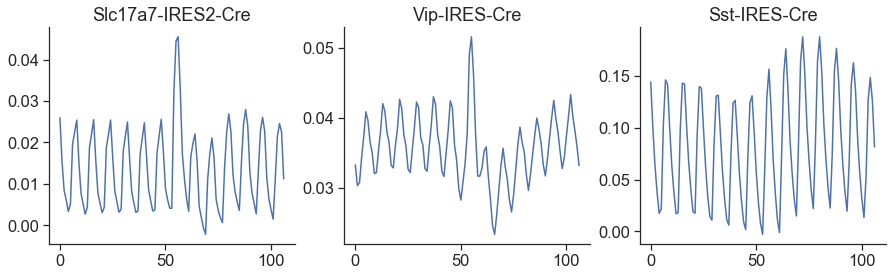

In [28]:
# average trace for each cre line
fig, ax = plt.subplots(1,3, figsize=(15,4))
for i,cre_line in enumerate(cre_lines): 
    ax[i].plot(np.nanmean(all_sess_ns_fof_all_cre[cre_line], axis=0))
    ax[i].set_title(cre_line)

### run PCA 

In [31]:
import visual_behavior.clustering.multiscope_fn.def_funs as funs

Running PCA on Slc17a7-IRES2-Cre, matrix size: (143757, 107)
(143757, 87)
Running PCA on Vip-IRES-Cre, matrix size: (34426, 107)
(34426, 76)
Running PCA on Sst-IRES-Cre, matrix size: (13282, 107)
(13282, 47)


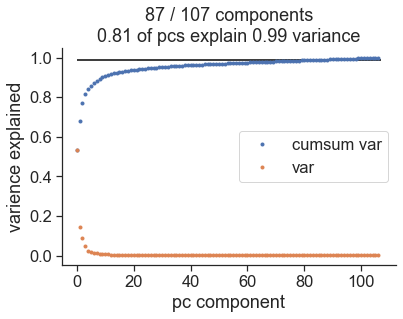

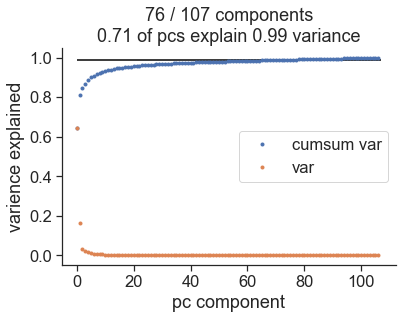

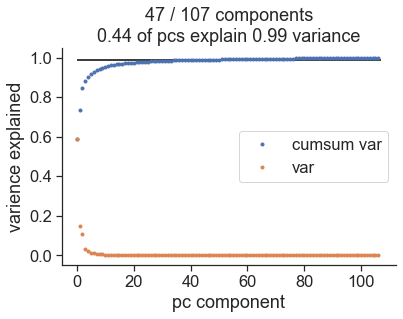

In [32]:
"""
Vars needed here are set in umap_set_vars.py

Here we run umap and pca on the data matrix created in umap_set_vars.py.

After this script run umap_plots.py to make plots.

Created on Mon Jun 29 11:31:25 2020
@author: farzaneh

"""


################################################################################################    
################################################################################################        
#%% Run PCA on all_sess_ns_fof_this_cre
################################################################################################    
################################################################################################    

from sklearn.decomposition import PCA
varexpmax = .99 # 1 # .9

pc_all_cre = {}
pca_variance_all_cre = {}

for cre_line in cre_lines: # icre=0
    all_sess_ns_fof_thisCre = all_sess_ns_fof_all_cre[cre_line] # neurons_allExp_thisCre x 24(frames)
    print(f'Running PCA on {cre_line}, matrix size: {np.shape(all_sess_ns_fof_thisCre)}')

    x_train_pc, pca = funs.doPCA(all_sess_ns_fof_thisCre, varexpmax=varexpmax, doplot=1)
    pca_variance = pca.explained_variance_ratio_
#     x_train_pc.shape

    pc_all_cre[cre_line] = x_train_pc
    pca_variance_all_cre[cre_line] = pca_variance
    
    


### run UMAP

In [33]:
################################################################################################    
################################################################################################    
#%% Run umap on all_sess_ns_fof_thisCre
################################################################################################
################################################################################################

import umap    
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

ncomp = 2 # 3 # number of umap components

embedding_all_cre = {}

for cre_line in cre_lines: # icre = 2    
    all_sess_ns_fof_thisCre = all_sess_ns_fof_all_cre[cre_line] # neurons_allExp_thisCre x 24(frames)
    print(f'Running UMAP on {cre_line}')

    sp = 2
    neigh = 7
    embedding = umap.UMAP(spread= sp, n_neighbors = neigh, n_components = ncomp).fit_transform(all_sess_ns_fof_thisCre)
    print(f'embedding size: {embedding.shape}')
    embedding_all_cre[cre_line] = embedding
    
# embedding_all_cre_3d = copy.deepcopy(embedding_all_cre)

    
    
###########################################################################
#%% After this script, run umap_plot.py to make plots for umap/pca analysis.    
###########################################################################

Running UMAP on Slc17a7-IRES2-Cre
embedding size: (143757, 2)
Running UMAP on Vip-IRES-Cre
embedding size: (34426, 2)
Running UMAP on Sst-IRES-Cre
embedding size: (13282, 2)


### get some things to label with

In [34]:
df['session_number'] = [int(session_number) for session_number in df.session_number.values]

In [38]:
mean_change_response = {}
depth = {}
imaging_depth = {}
targeted_structure = {}
session_number = {}
change_image_name = {}
for cre_line in cre_lines:
    mean_change_response[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].mean_response.values))
    depth[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].depth.values))
    imaging_depth[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].imaging_depth.values))
    session_number[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].session_number.values))
    targeted_structure[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].targeted_structure.values))
    change_image_name[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].change_image_name.values))


### plots 

#### colored by mean omission response

In [39]:
low_dim_all_cre = embedding_all_cre

c_value = mean_change_response.copy()
vmin = np.percentile(df.mean_response.values, 5)
vmax = np.percentile(df.mean_response.values, 95)

Text(0, 0.5, 'mean change response')

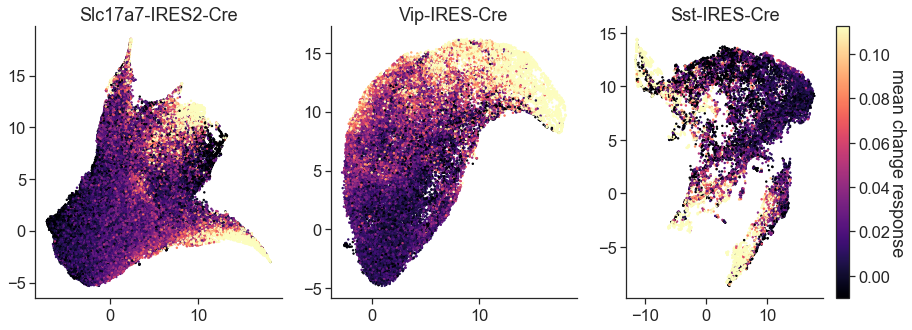

In [40]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, cre_line in enumerate(cre_lines):
    x = low_dim_all_cre[cre_line][:, 0]
    y = low_dim_all_cre[cre_line][:, 1]
    cax = ax[i].scatter(x, y, s=2, label=cre_line, marker='o', c=c_value[cre_line], cmap='magma', vmin=vmin, vmax=vmax)
    ax[i].set_title(cre_line)
cbar = plt.colorbar(cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('mean change response', rotation=270)

#### colored by image

In [41]:
# low_dim_all_cre = embedding_all_cre

# c_value = change_image_name.copy()


In [47]:
# low_dim_all_cre[cre_line]


(143757, 2)

In [53]:
# fig, ax = plt.subplots(1,3, figsize=(15,5))
# for i, cre_line in enumerate(cre_lines):
#     for c, change_image_name in enumerate(c_value)
#         x = low_dim_all_cre[cre_line][:, 0]
#         y = low_dim_all_cre[cre_line][:, 1]
#         cax = ax[i].scatter(x, y, s=2, label=cre_line, marker='o', c=c_value[cre_line], color=)
#         ax[i].set_title(cre_line)
# cbar = plt.colorbar(cax)
# cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel('change image name', rotation=270)

#### colored by imaging depth

In [49]:
low_dim_all_cre = embedding_all_cre

c_value = imaging_depth.copy()

Text(0, 0.5, 'imaging_depth')

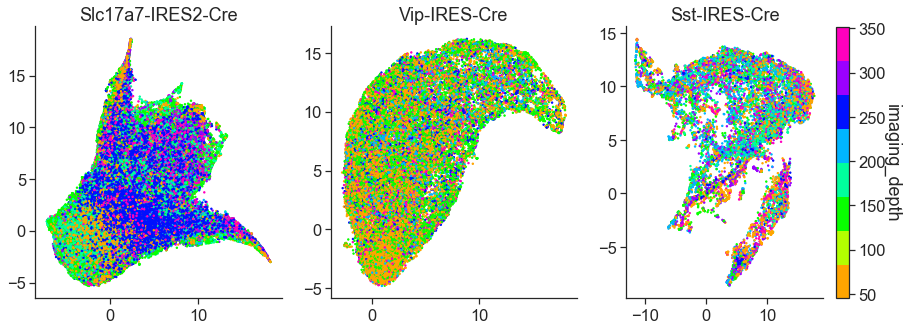

In [50]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette('hsv', 8).as_hex())


fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, cre_line in enumerate(cre_lines):
    x = low_dim_all_cre[cre_line][:, 0]
    y = low_dim_all_cre[cre_line][:, 1]
    cax = ax[i].scatter(x, y, s=2, label=cre_line, marker='o', c=c_value[cre_line], cmap=cmap)
    ax[i].set_title(cre_line)
cbar = plt.colorbar(cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('imaging_depth', rotation=270)

#### colored by session_number

In [51]:
low_dim_all_cre = embedding_all_cre

c_value = session_number.copy()
vmin = 1
vmax = 6

Text(0, 0.5, 'session_number')

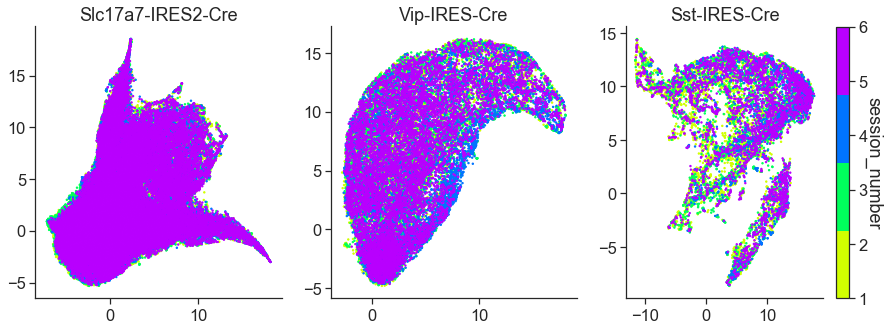

In [52]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette('hsv', 4).as_hex())

fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, cre_line in enumerate(cre_lines):
    x = low_dim_all_cre[cre_line][:, 0]
    y = low_dim_all_cre[cre_line][:, 1]
    cax = ax[i].scatter(x, y, s=2, label=cre_line, marker='o', c=c_value[cre_line], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(cre_line)
cbar = plt.colorbar(cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('session_number', rotation=270)